# Temporal Difference Method

### Import libraries

In [18]:
%matplotlib inline
import sys
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd

from collections import defaultdict
from gridworld import GridworldEnv
import plotting

matplotlib.style.use('ggplot')

### Policy function

In [19]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        #####
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        #####
        return A
    return policy_fn

### Q learning

In [20]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        #####
        state = env.reset()
        for t in itertools.count(): #무한반복
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            greedy_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + discount_factor*Q[next_state][greedy_next_action] - Q[state][action])
            state = next_state
            
            if done:
                break
        #####


    
    return Q, stats

### Executable codes

In [21]:
def main():
    env = GridworldEnv()
    Q, stats = q_learning(env, 500)
    _, _, _ = plotting.plot_episode_stats(stats)
    
    policy = make_epsilon_greedy_policy(Q, 0, env.nA)
    policy_table = np.array([policy(s) for s in range(env.nS)])

    V = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        V[state] = action_value
    V = np.array([ V[s] for s in range(env.nS)])
    
    # Policy Iteration
    print("--------TD method---------")
    print(policy_table)

    print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
    print(np.reshape(np.argmax(policy_table, axis=1), env.shape))
    print("")

    print("Reshaped Grid Value Function:")
    print(V.reshape(env.shape))

    print("")
    print("---------------------------------")


Episode 500/500.

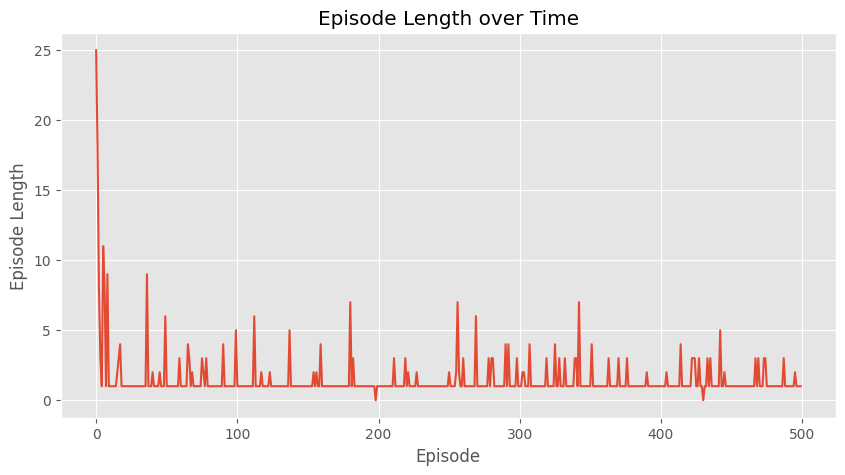

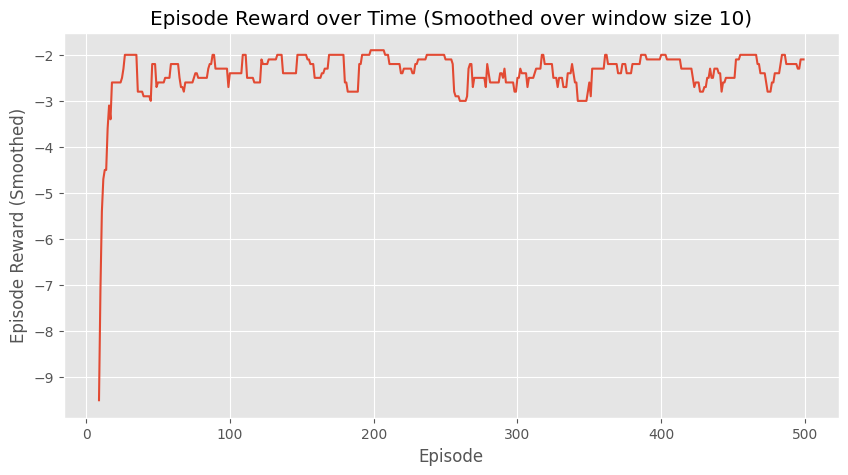

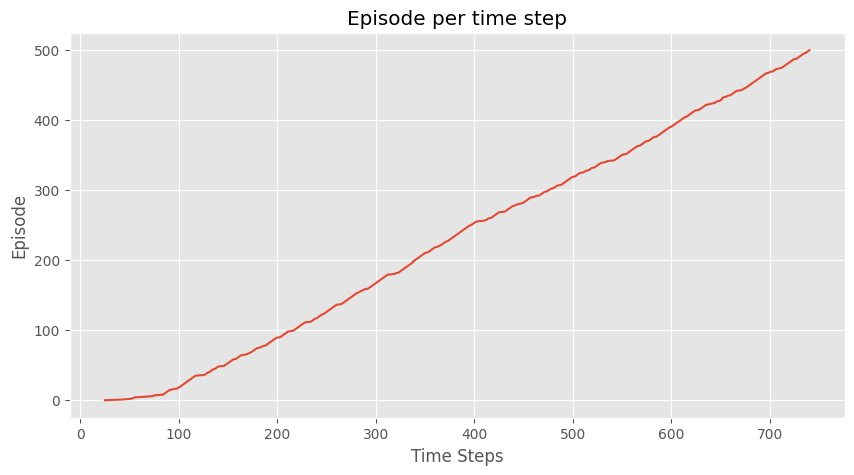

--------TD method---------
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 0 3]
 [0 2 2]
 [1 2 3]
 [1 0 3]]

Reshaped Grid Value Function:
[[ 0.          0.         -2.65625   ]
 [ 0.         -2.         -2.99556343]
 [-1.8515625  -1.         -1.9995117 ]
 [-0.984375    0.         -0.99996948]]

---------------------------------


In [24]:
if __name__=='__main__':
    main()